In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon,LineString
from shapely.ops import linemerge, unary_union, polygonize
import scipy.stats as stats
import scipy.interpolate as interp
import os

/home/kfitzmaurice/anaconda3/envs/flooding/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
pwd = os.getcwd()

# Specify crs
chosen_crs = 'EPSG:32617'

# Read in contours
contours_filepath = os.path.join(pwd,'data/elevation/contours')
contours = gpd.read_file(contours_filepath)

# Read in trails
trails_filepath = os.path.join(pwd,'data/trails/West_Virginia_Trail_Inventory/WV_Trail_Inventory.shp')
trails = gpd.read_file(trails_filepath)

# Read in roads
roads_filepath = os.path.join(pwd,'data/roads/US_Routes/US_Highways.shp')
roads = gpd.read_file(roads_filepath)

# Clip and reproject contours 
xmin = -81.0134
xmax = -81.12606
ymin = 38.02143
ymax = 38.10576

poly_geom = Polygon([[xmin,ymax],[xmax,ymax],[xmax,ymin],[xmin,ymin]])
poly_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[poly_geom])
poly_gdf = poly_gdf.to_crs(chosen_crs)

# Find square box that best fits domain and which is an integer number of km in length
xmin,ymin,xmax,ymax = np.round(poly_gdf['geometry'].bounds.values[0],-3)
L = max((xmax-xmin),(ymax-ymin))-2000
xmin = xmin+1500
ymin = ymin
xmax = xmin+L
ymax = ymin+L

extent_geom = Polygon([[xmin,ymax],[xmax,ymax],[xmax,ymin],[xmin,ymin]])
extent_gdf = gpd.GeoDataFrame(index=[0], crs=chosen_crs, geometry=[extent_geom])

border = extent_gdf.copy()
border['geometry'] = border['geometry'].boundary

# Clip contours by extent
#contours = contours.set_crs('EPSG:4326',allow_override=True).to_crs(chosen_crs)
contours = contours.to_crs(chosen_crs)
contours = contours[contours.intersects(extent_gdf['geometry'].values[0])]
contours['geometry'] = contours['geometry'].intersection(extent_gdf['geometry'].values[0].buffer(1000))

# Clip trails by extent
trails = trails.to_crs(chosen_crs)
trails = trails[trails.intersects(extent_gdf['geometry'].values[0])]
#trails['geometry'] = trails['geometry'].intersection(extent_gdf['geometry'].values[0])

# Clip roads by extent
roads = roads.to_crs(chosen_crs)
roads = roads[roads.intersects(extent_gdf['geometry'].values[0])]
#roads['geometry'] = roads['geometry'].intersection(extent_gdf['geometry'].values[0])

# Make elevations integer values
contours['ELEV'] = contours['ELEV'].apply(lambda x: int(x))
contours = contours.dissolve(by='ELEV').reset_index().drop(columns=['fid','ID'])
contours 

,ELEV,geometry
0,300,"MULTILINESTRING ((491041.228 4217000.000, 4910..."
1,350,"MULTILINESTRING ((490949.215 4217000.000, 4909..."
2,400,"MULTILINESTRING ((490883.082 4217000.000, 4908..."
3,450,"MULTILINESTRING ((489504.273 4216086.989, 4895..."
4,500,"MULTILINESTRING ((493898.168 4215715.063, 4938..."
5,550,"MULTILINESTRING ((496347.425 4215413.198, 4963..."
6,600,"MULTILINESTRING ((497224.802 4215943.450, 4972..."
7,650,"MULTILINESTRING ((496310.225 4215960.935, 4963..."


<Axes: >

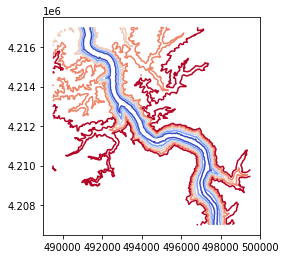

In [3]:
# Determine max elevation to display on map
max_elevation=550
contours[contours['ELEV']<=max_elevation].plot(column='ELEV',cmap='coolwarm')

In [4]:
# Filter out contours less than this elevation
contours = contours[contours['ELEV']<=max_elevation]
contours

,ELEV,geometry
0,300,"MULTILINESTRING ((491041.228 4217000.000, 4910..."
1,350,"MULTILINESTRING ((490949.215 4217000.000, 4909..."
2,400,"MULTILINESTRING ((490883.082 4217000.000, 4908..."
3,450,"MULTILINESTRING ((489504.273 4216086.989, 4895..."
4,500,"MULTILINESTRING ((493898.168 4215715.063, 4938..."
5,550,"MULTILINESTRING ((496347.425 4215413.198, 4963..."


In [5]:
# Read in info on waterbodies
waterbody_dir = os.path.join(pwd,'data/waterbodies')
waterbody_filepaths = [os.path.join(waterbody_dir,x,'Shape/NHDArea.shp') for x in os.listdir(waterbody_dir) if 'NHD' in x]

df_list = []
for filepath in waterbody_filepaths:
    df_list.append(gpd.read_file(filepath))
    
waterbodies = pd.concat(df_list).reset_index(drop=True)

In [6]:
# Clip waterbodies by extent
waterbodies = waterbodies.to_crs(chosen_crs)
waterbodies = waterbodies[waterbodies.intersects(extent_gdf['geometry'].values[0])]

In [7]:
# Smooth lines
# smoothing_factor = 20
# contours['geometry'] = contours['geometry'].buffer(smoothing_factor, join_style=1).buffer(-1*smoothing_factor, join_style=1)
# waterbodies['geometry'] = waterbodies['geometry'].buffer(smoothing_factor, join_style=1).buffer(-1*smoothing_factor, join_style=1)

In [8]:
# Add area boundary to elevation contours
#contours['geometry'] = contours['geometry'].union(extent_gdf['geometry'].boundary.values[0])
#waterbodies['geometry'] = waterbodies['geometry'].boundary
#waterbodies['geometry'] = waterbodies['geometry'].union(extent_gdf['geometry'].boundary.values[0])

In [9]:
# Smooth using B-splines


In [10]:
def smooth_lines(input_linestring,s_mult=700):
    """
    Smooth lines using B-splines
    
    param: input_linestring: original shapely LineString
    param: s_mult: multiplier to smoothing factor (make 0 for interpolation)
    returns: smoothed_linestring: smoothed version of input linestring
    """
    
    x,y = input_linestring.coords.xy

    m=len(x)
    s = s_mult*m

    tck, extra = interp.splprep([x,y],s=s)
    u = np.linspace(0,1,m)
    x_smooth,y_smooth=interp.splev(u,tck)
    coords_smooth = np.array([x_smooth,y_smooth]).T
    smoothed_linestring = LineString(coordinates=coords_smooth)
    
    return(smoothed_linestring)

def smooth_contours(contours,s_mult=700,agg_column=None):
    
    gdf = contours.explode().reset_index()
    gdf['geometry'] = gdf['geometry'].apply(smooth_lines,args=(s_mult,))
    
    smoothed_contours = gdf.dissolve(by=agg_column).reset_index().drop(columns=['level_0','level_1'])
    
    return(smoothed_contours)

def remove_contour_islands(contours,min_area,agg_column=None):
    """
    Remove islands from elevation contours if below certain size threshold
    (probably too small for laser cutter)
    """
    
    gdf = contours.explode().reset_index()
    gdf['area'] = gdf['geometry'].convex_hull.area
    gdf = gdf[gdf['area'] > min_area]
    gdf = gdf.dissolve(by=agg_column).reset_index().drop(columns=['level_0','level_1','area'])
    
    return(gdf)

/tmp/ipykernel_687/1618369853.py:25: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf = contours.explode().reset_index()
/tmp/ipykernel_687/1618369853.py:38: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf = contours.explode().reset_index()


<Axes: >

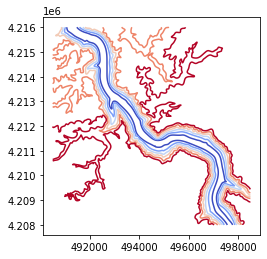

In [11]:
smoothed_contours = smooth_contours(contours,s_mult=50,agg_column='ELEV')
smoothed_contours['geometry'] = smoothed_contours['geometry'].intersection(extent_gdf['geometry'].values[0])
smoothed_contours = remove_contour_islands(smoothed_contours,min_area=40000,agg_column='ELEV')
smoothed_contours.plot(column='ELEV',cmap='coolwarm')

In [12]:
# Apply buffer to make rivers stand out more
water_contour = waterbodies.copy()
water_contour['geometry'] = water_contour['geometry'].buffer(10)
water_contour['geometry'] = water_contour['geometry'].boundary
water_contour = smooth_contours(water_contour,s_mult=50)
water_contour['geometry'] = water_contour['geometry'].intersection(extent_gdf['geometry'].values[0])

/tmp/ipykernel_687/1618369853.py:25: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf = contours.explode().reset_index()


/home/kfitzmaurice/anaconda3/envs/flooding/lib/python3.9/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_687/3817003801.py:9: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  line_split_collection = smoothed_contours[m]['geometry'].explode().to_list()


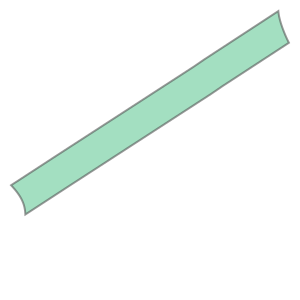

In [13]:
# Get bridge line segment from road
plot_roads = roads.iloc[1:2]
w_mult = 4
plot_roads['geometry'] = plot_roads['geometry'].buffer(w_mult*11.25)

road_elev = 500
m = (smoothed_contours['ELEV']==road_elev)

line_split_collection = smoothed_contours[m]['geometry'].explode().to_list()
polygon = plot_roads['geometry'].values[0]

def split_polygon_by_lines(polygon,line_split_collection):
    
    line_split_collection.append(polygon.boundary) 
    merged_lines = linemerge(line_split_collection)
    border_lines = unary_union(merged_lines)
    split_polygons = list(polygonize(border_lines))
    
    return(split_polygons)

split_polygons = split_polygon_by_lines(polygon,line_split_collection)
bridge = split_polygons[3]
bridge

In [14]:
# Add bridge to contours
smoothed_contours.loc[m,'geometry'] = smoothed_contours.loc[m,'geometry'].union(bridge.boundary)

In [15]:
# Add points of interest to test map 
points_df = pd.DataFrame([['Diamond Point Overlook',38.053241,-81.059575],
                          ['Long Point Overlook',38.059519,-81.077308],
                          ['Canyon Rim Visitor Center',38.070066,-81.075908],
                          ['Take-Out',38.067281,-81.082157]],columns=['Name','Lat','Lon'])

points_geometry = gpd.points_from_xy(points_df['Lon'],points_df['Lat'])
points_gdf = gpd.GeoDataFrame(data=points_df,geometry=points_geometry,crs='EPSG:4326')
points_gdf = points_gdf.to_crs(chosen_crs)

/tmp/ipykernel_687/2843293381.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


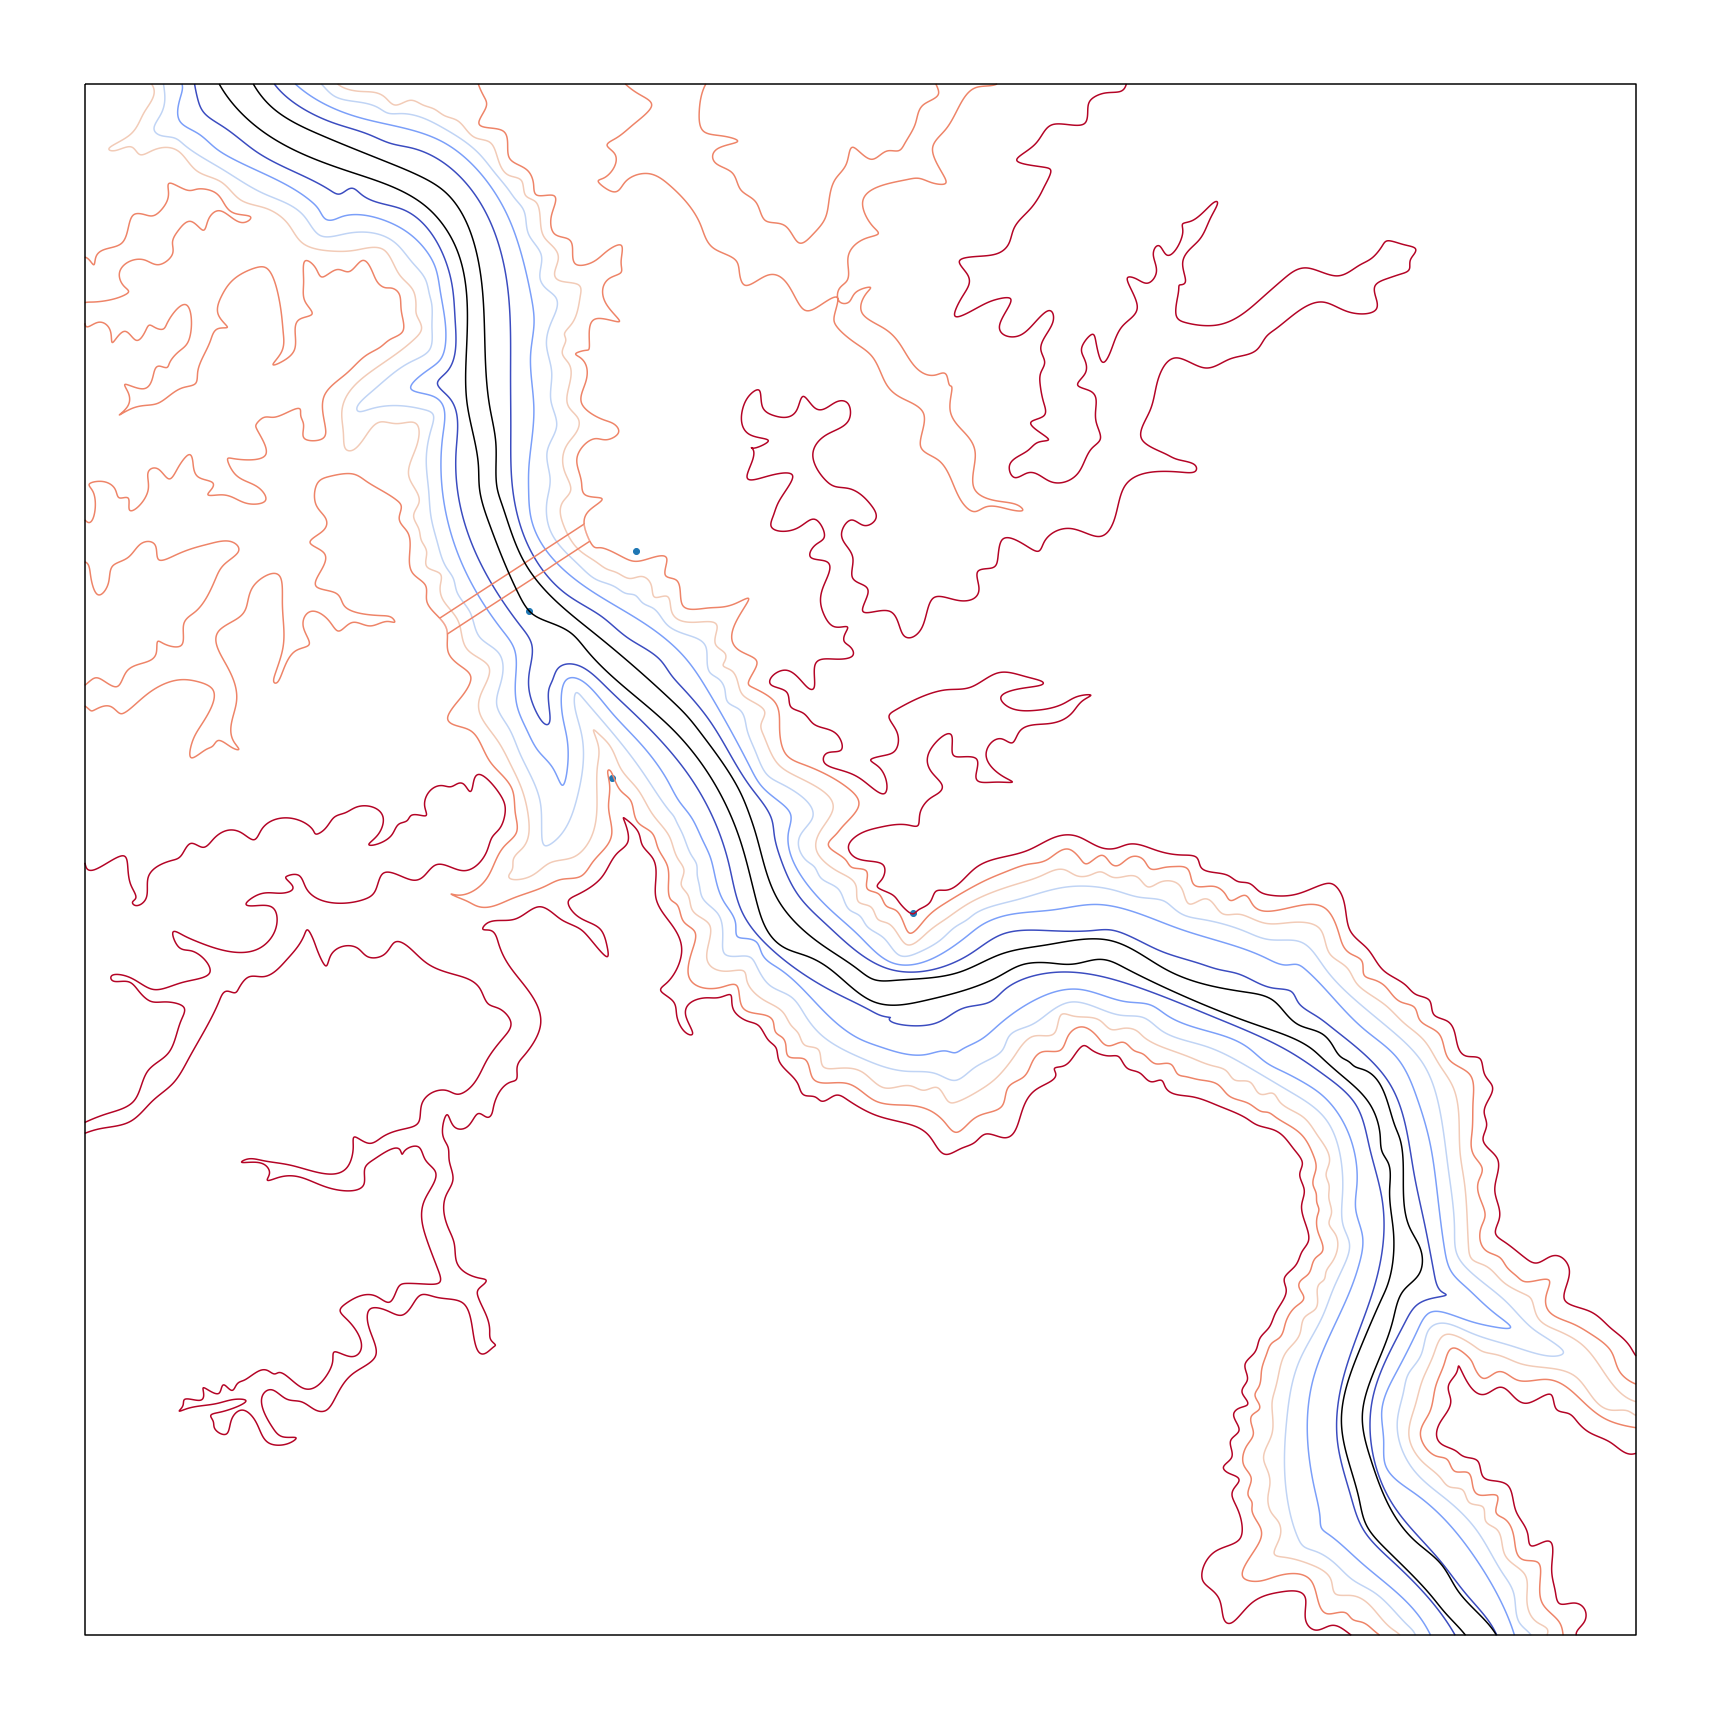

In [16]:
fig,ax = plt.subplots(figsize=(24,24))

smoothed_contours.plot(ax=ax,column='ELEV',cmap='coolwarm')
water_contour.plot(ax=ax,color='k')

points_gdf.plot(ax=ax,color='C0')

border.plot(ax=ax,color='k')

ax.axis('off')

fig.tight_layout()
fig.savefig('test.svg')
fig.show()

In [17]:
# Add border to contour lines
#smoothed_contours['geometry'] = smoothed_contours.union(border['geometry'].values[0])

# Add base to contours
border['ELEV'] = smoothed_contours['ELEV'].min() - 1
border = border[['ELEV','geometry']]
smoothed_contours = pd.concat([border,smoothed_contours],ignore_index=True).sort_values(by='ELEV').reset_index(drop=True)

In [18]:
# Add river to base
water_elev = smoothed_contours['ELEV'].min()
m = (smoothed_contours['ELEV']==water_elev)
smoothed_contours.loc[m,'geometry'] = smoothed_contours.loc[m,'geometry'].union(water_contour['geometry'].values[0])

1 km = 2.75 in


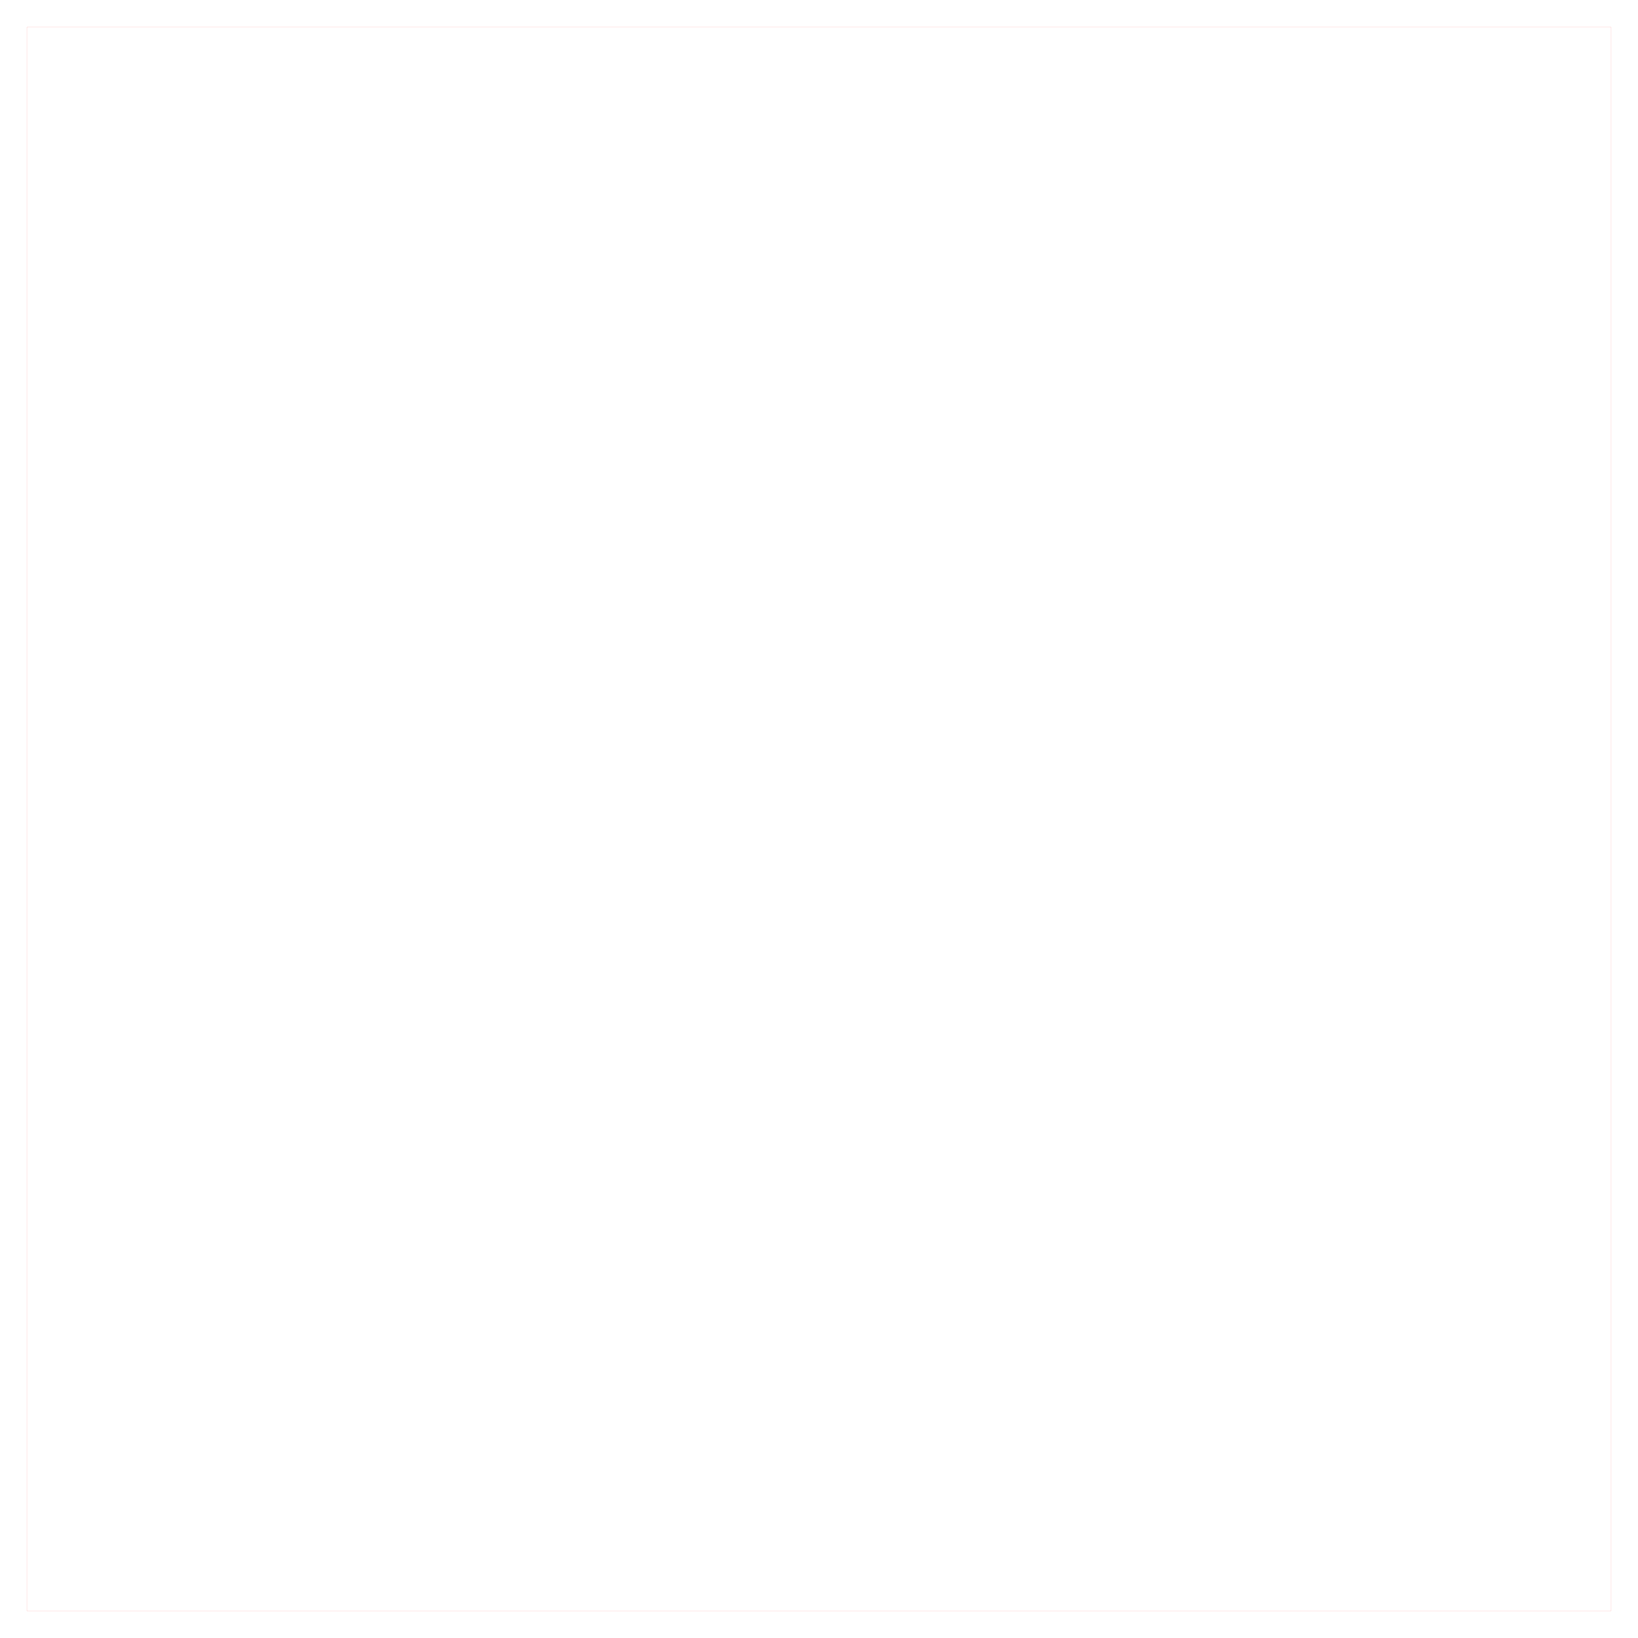

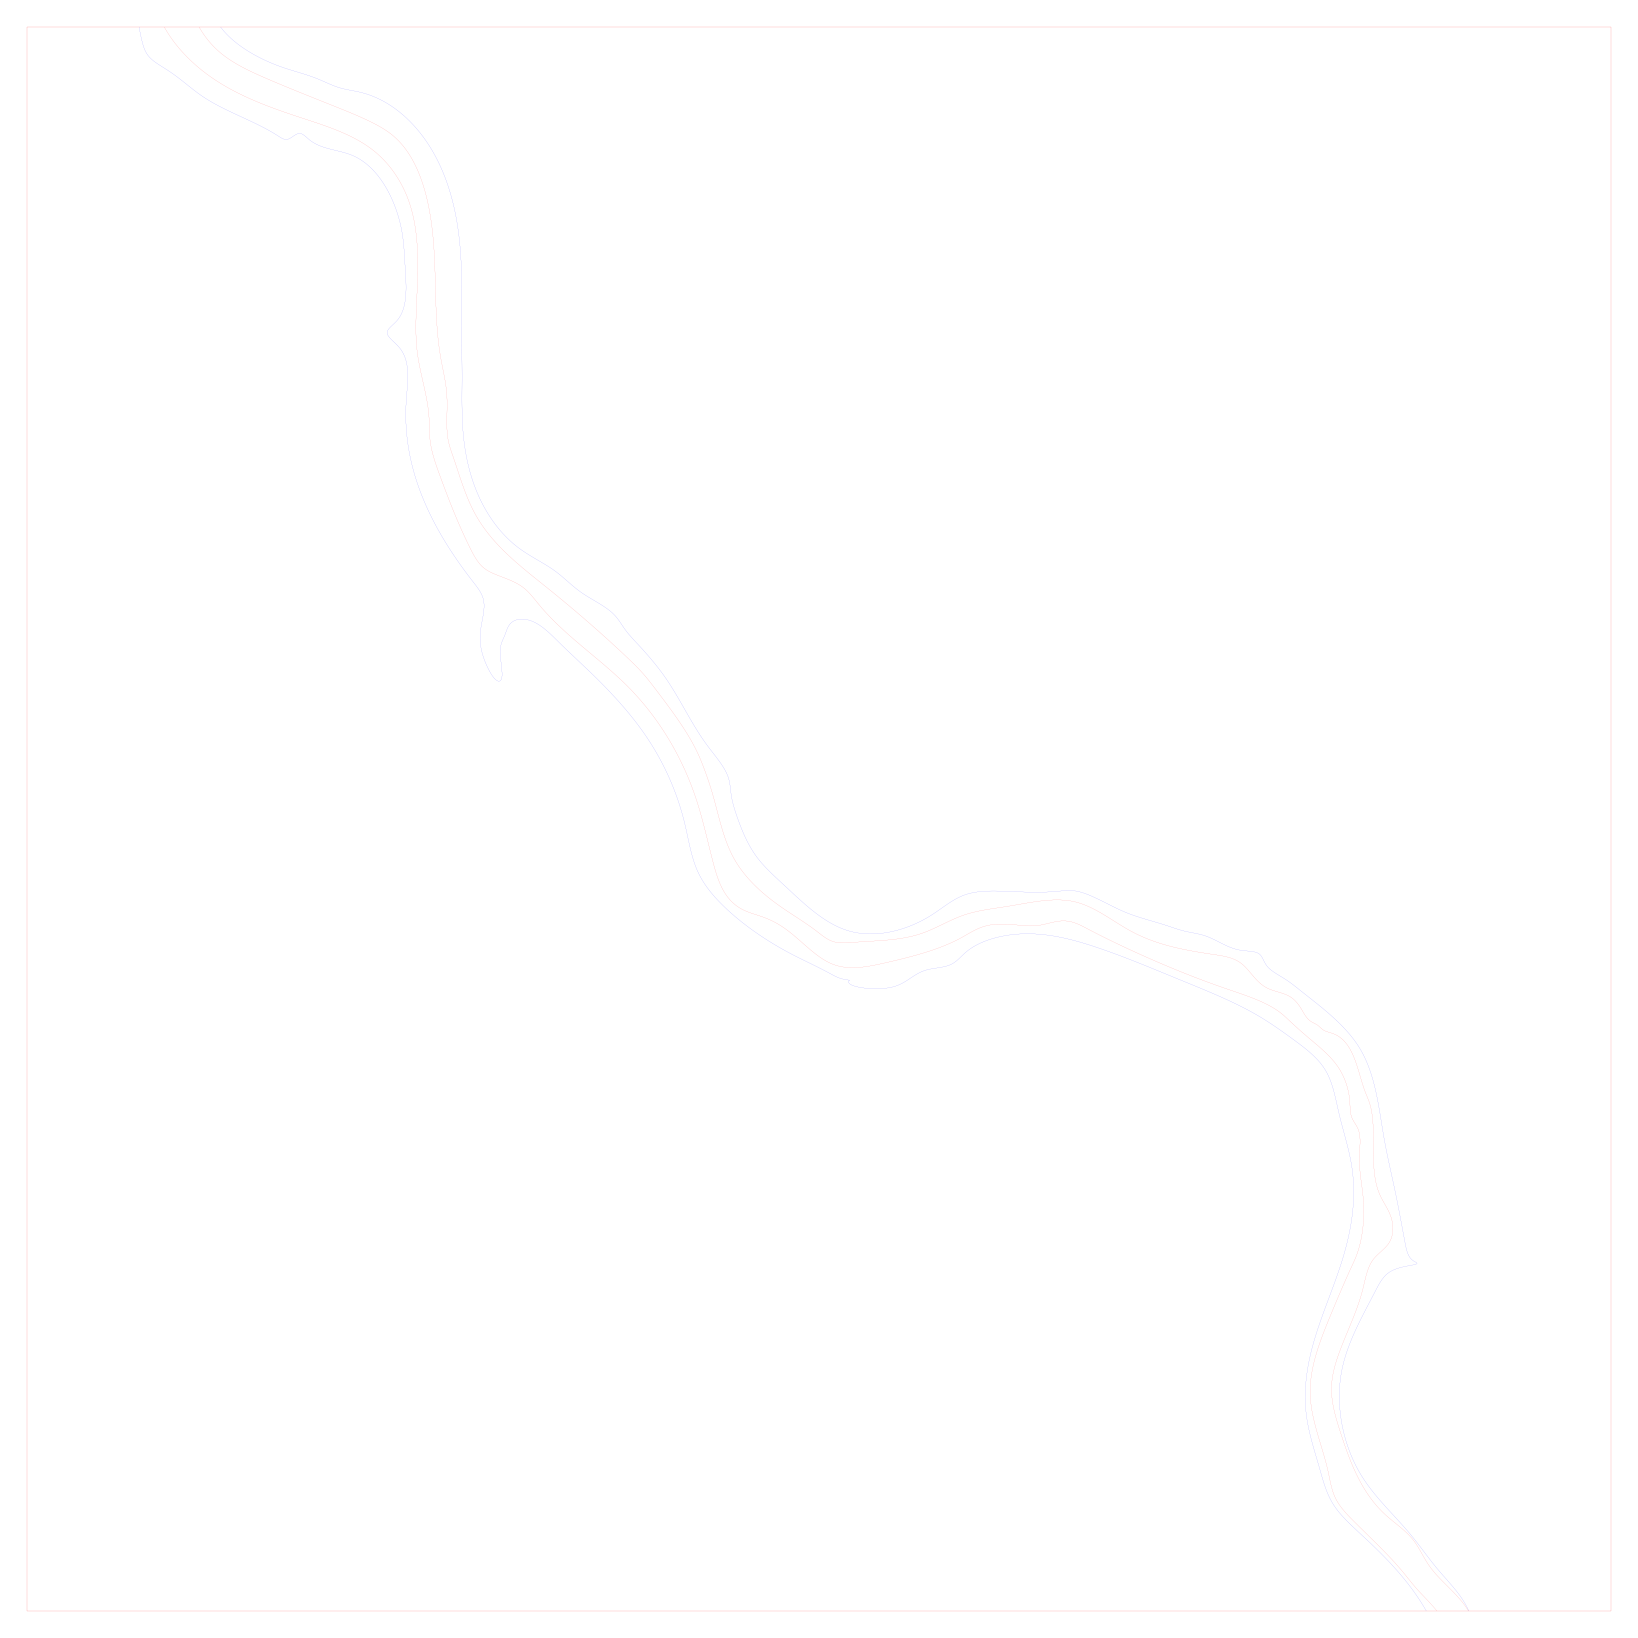

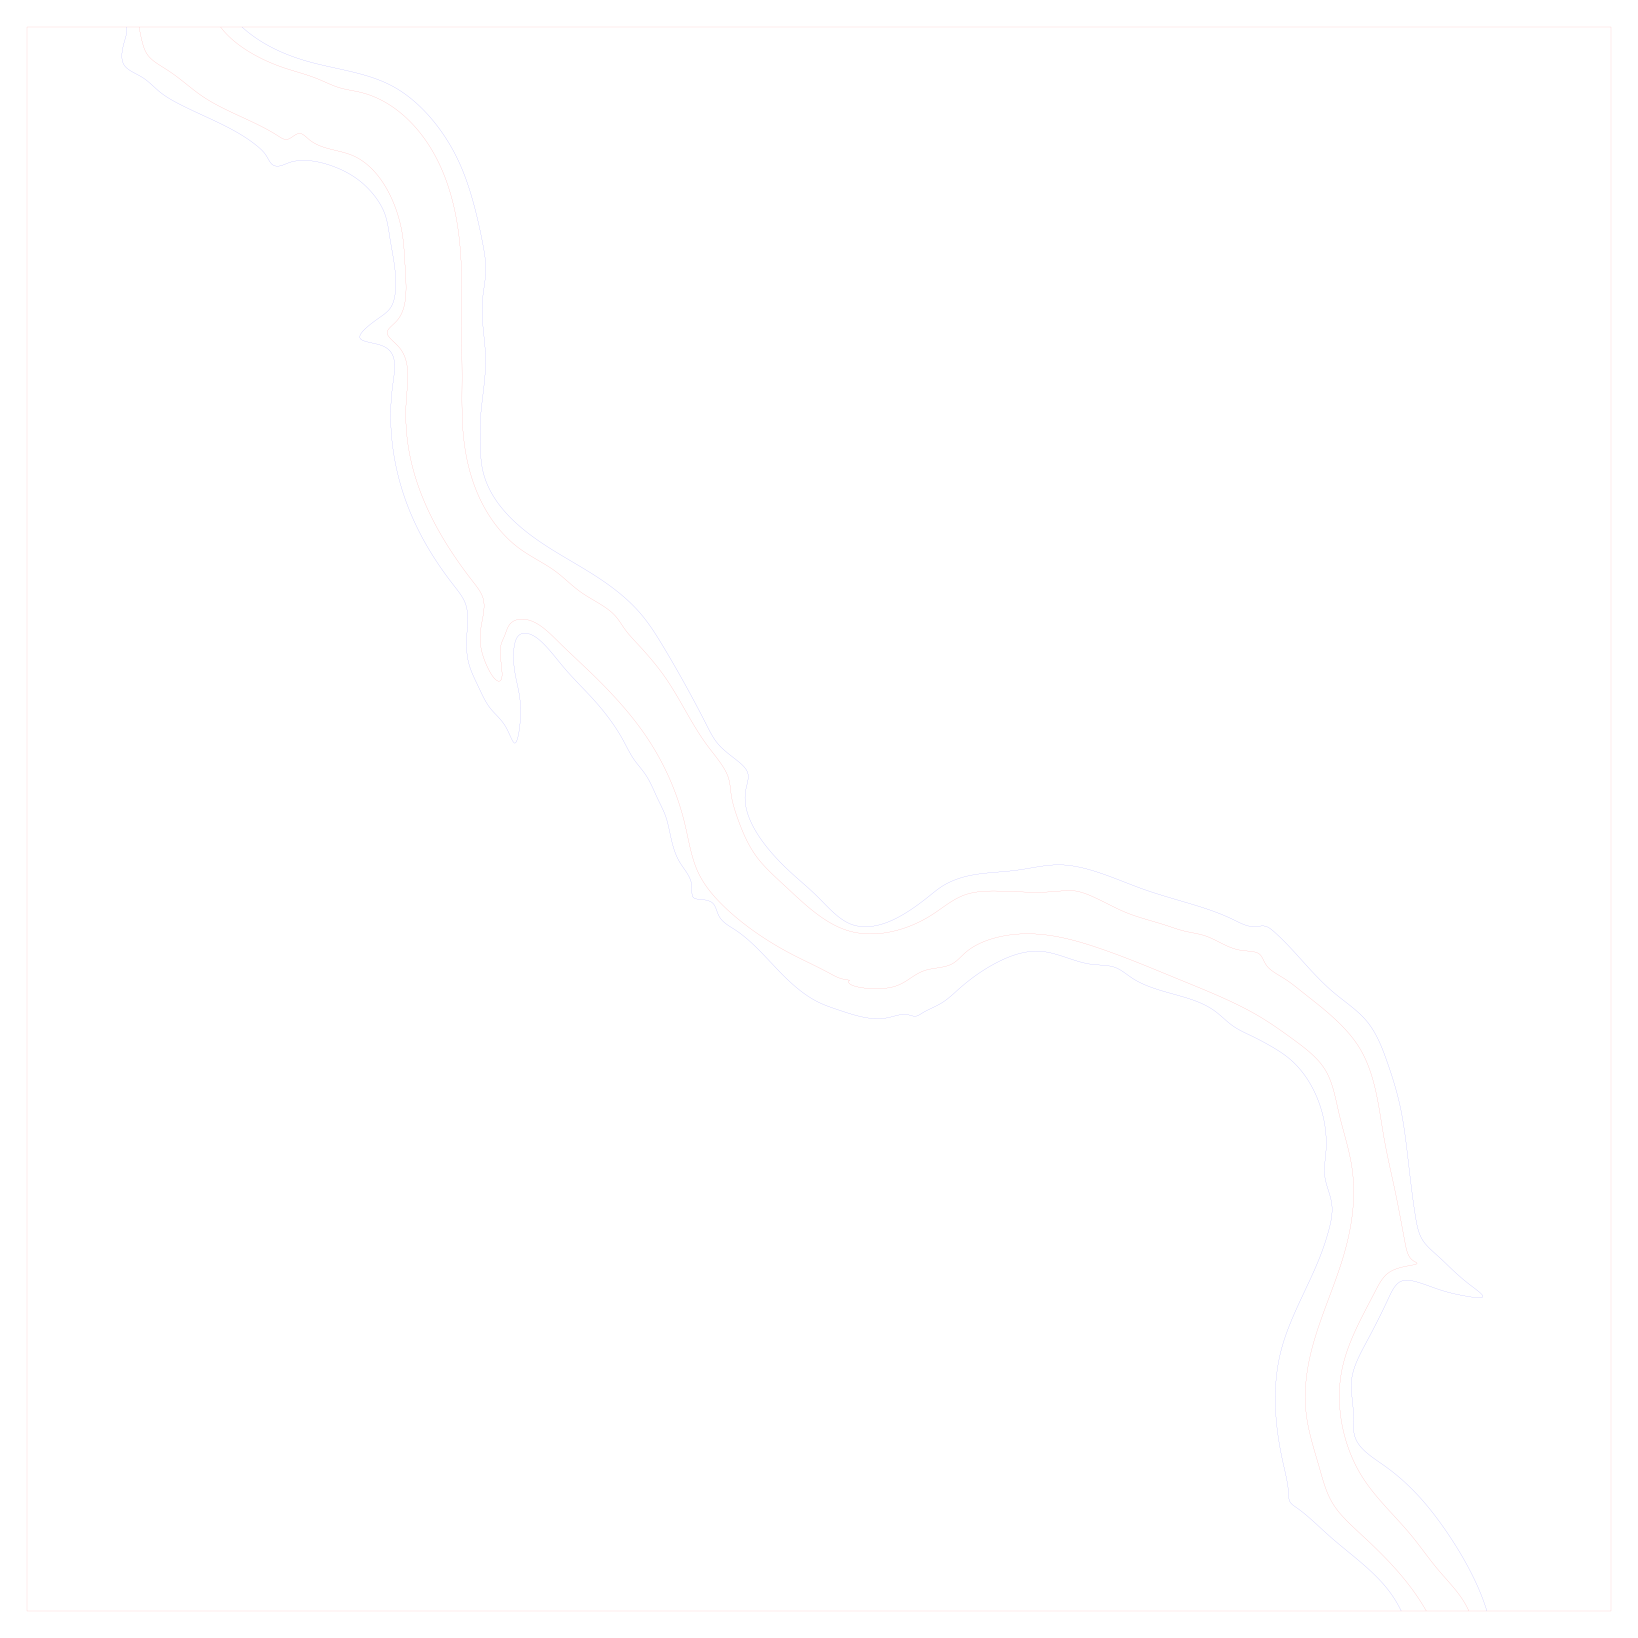

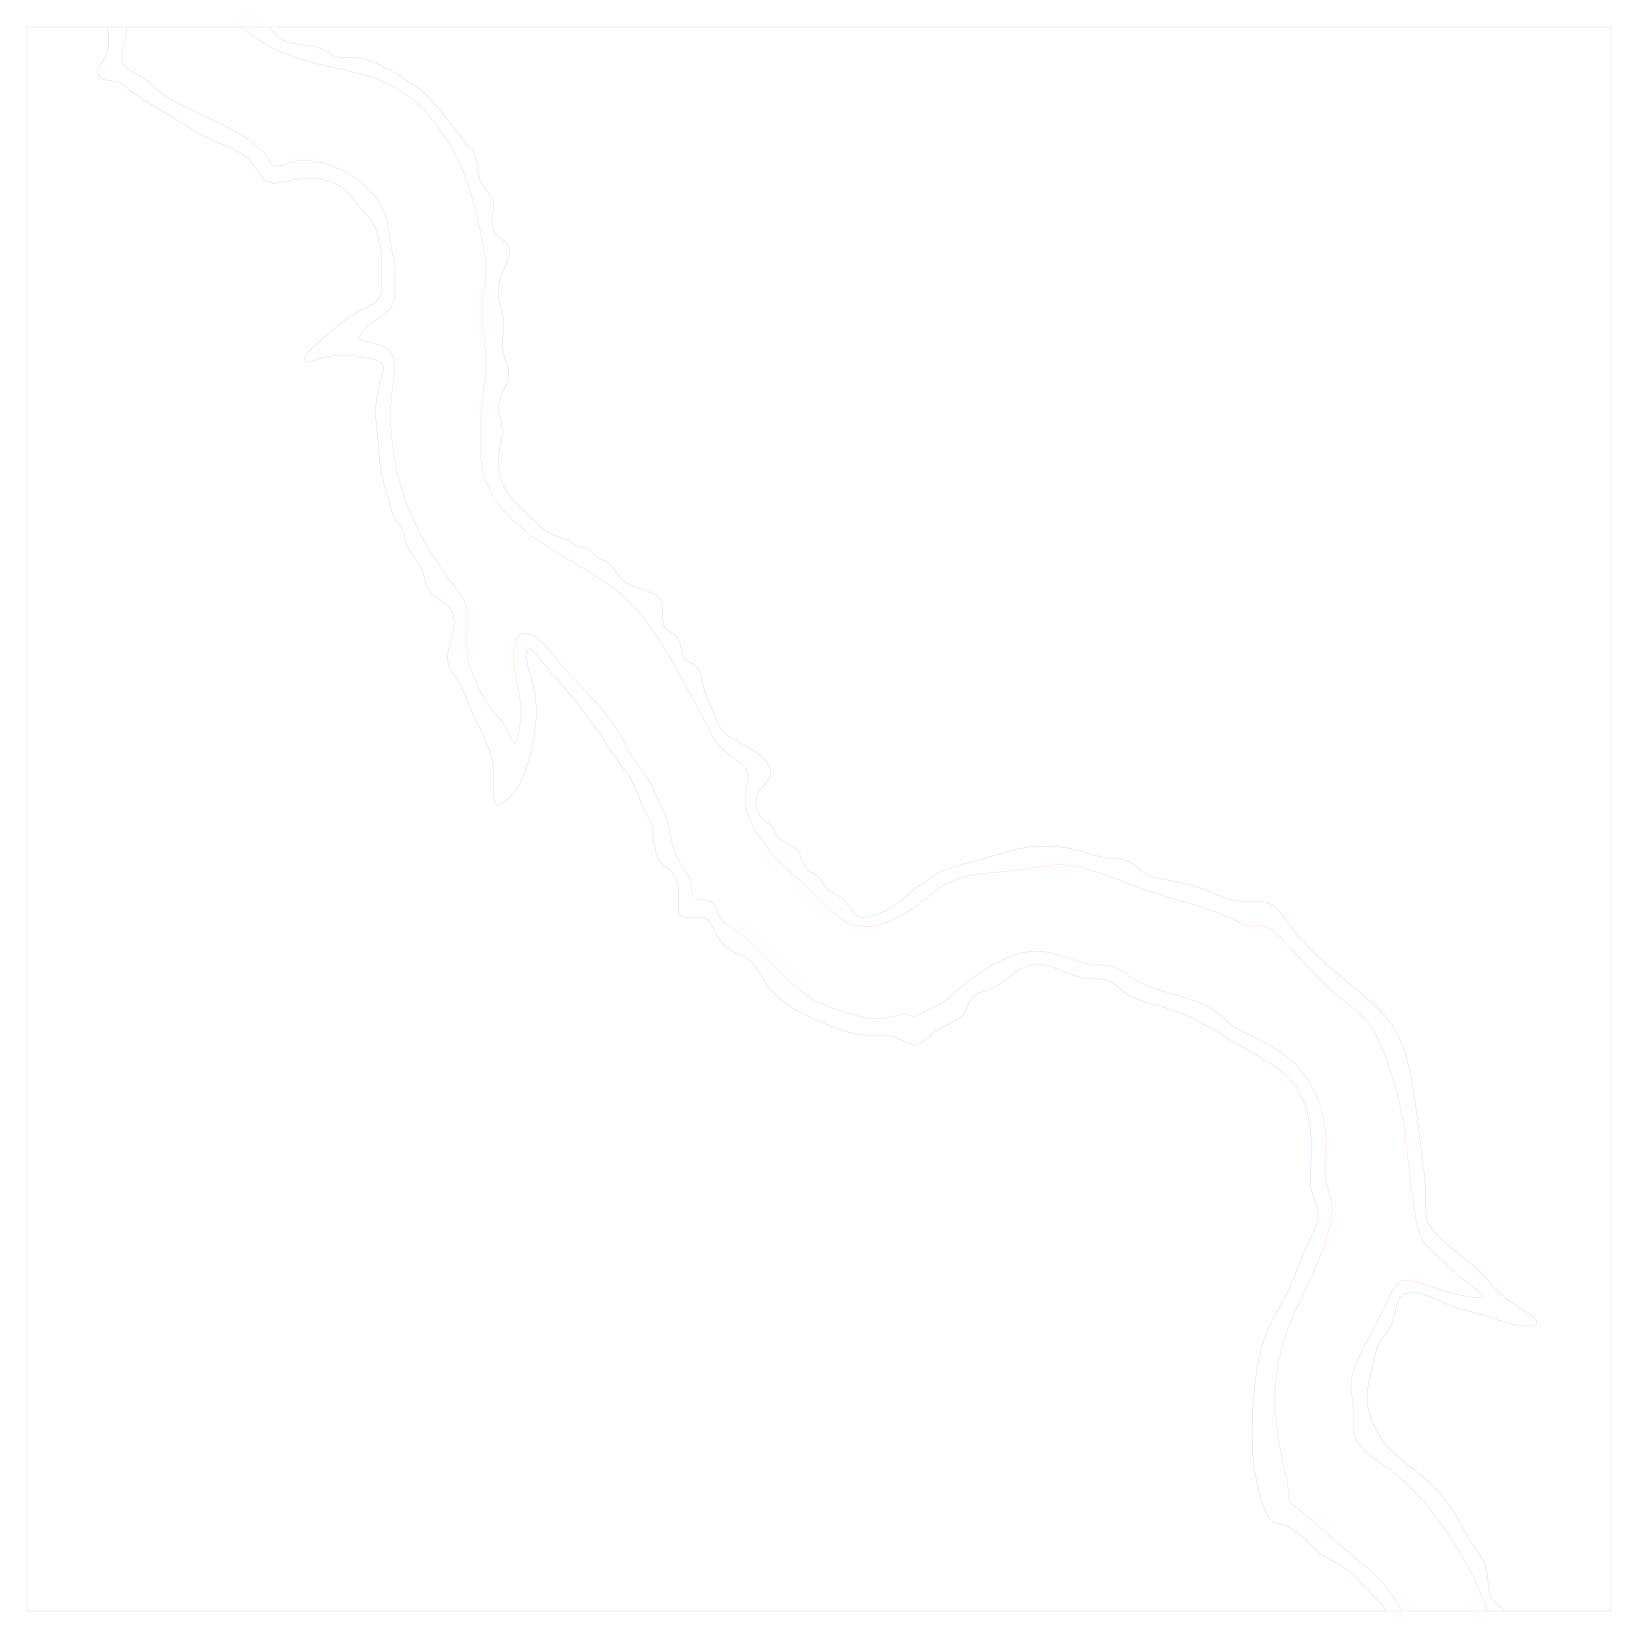

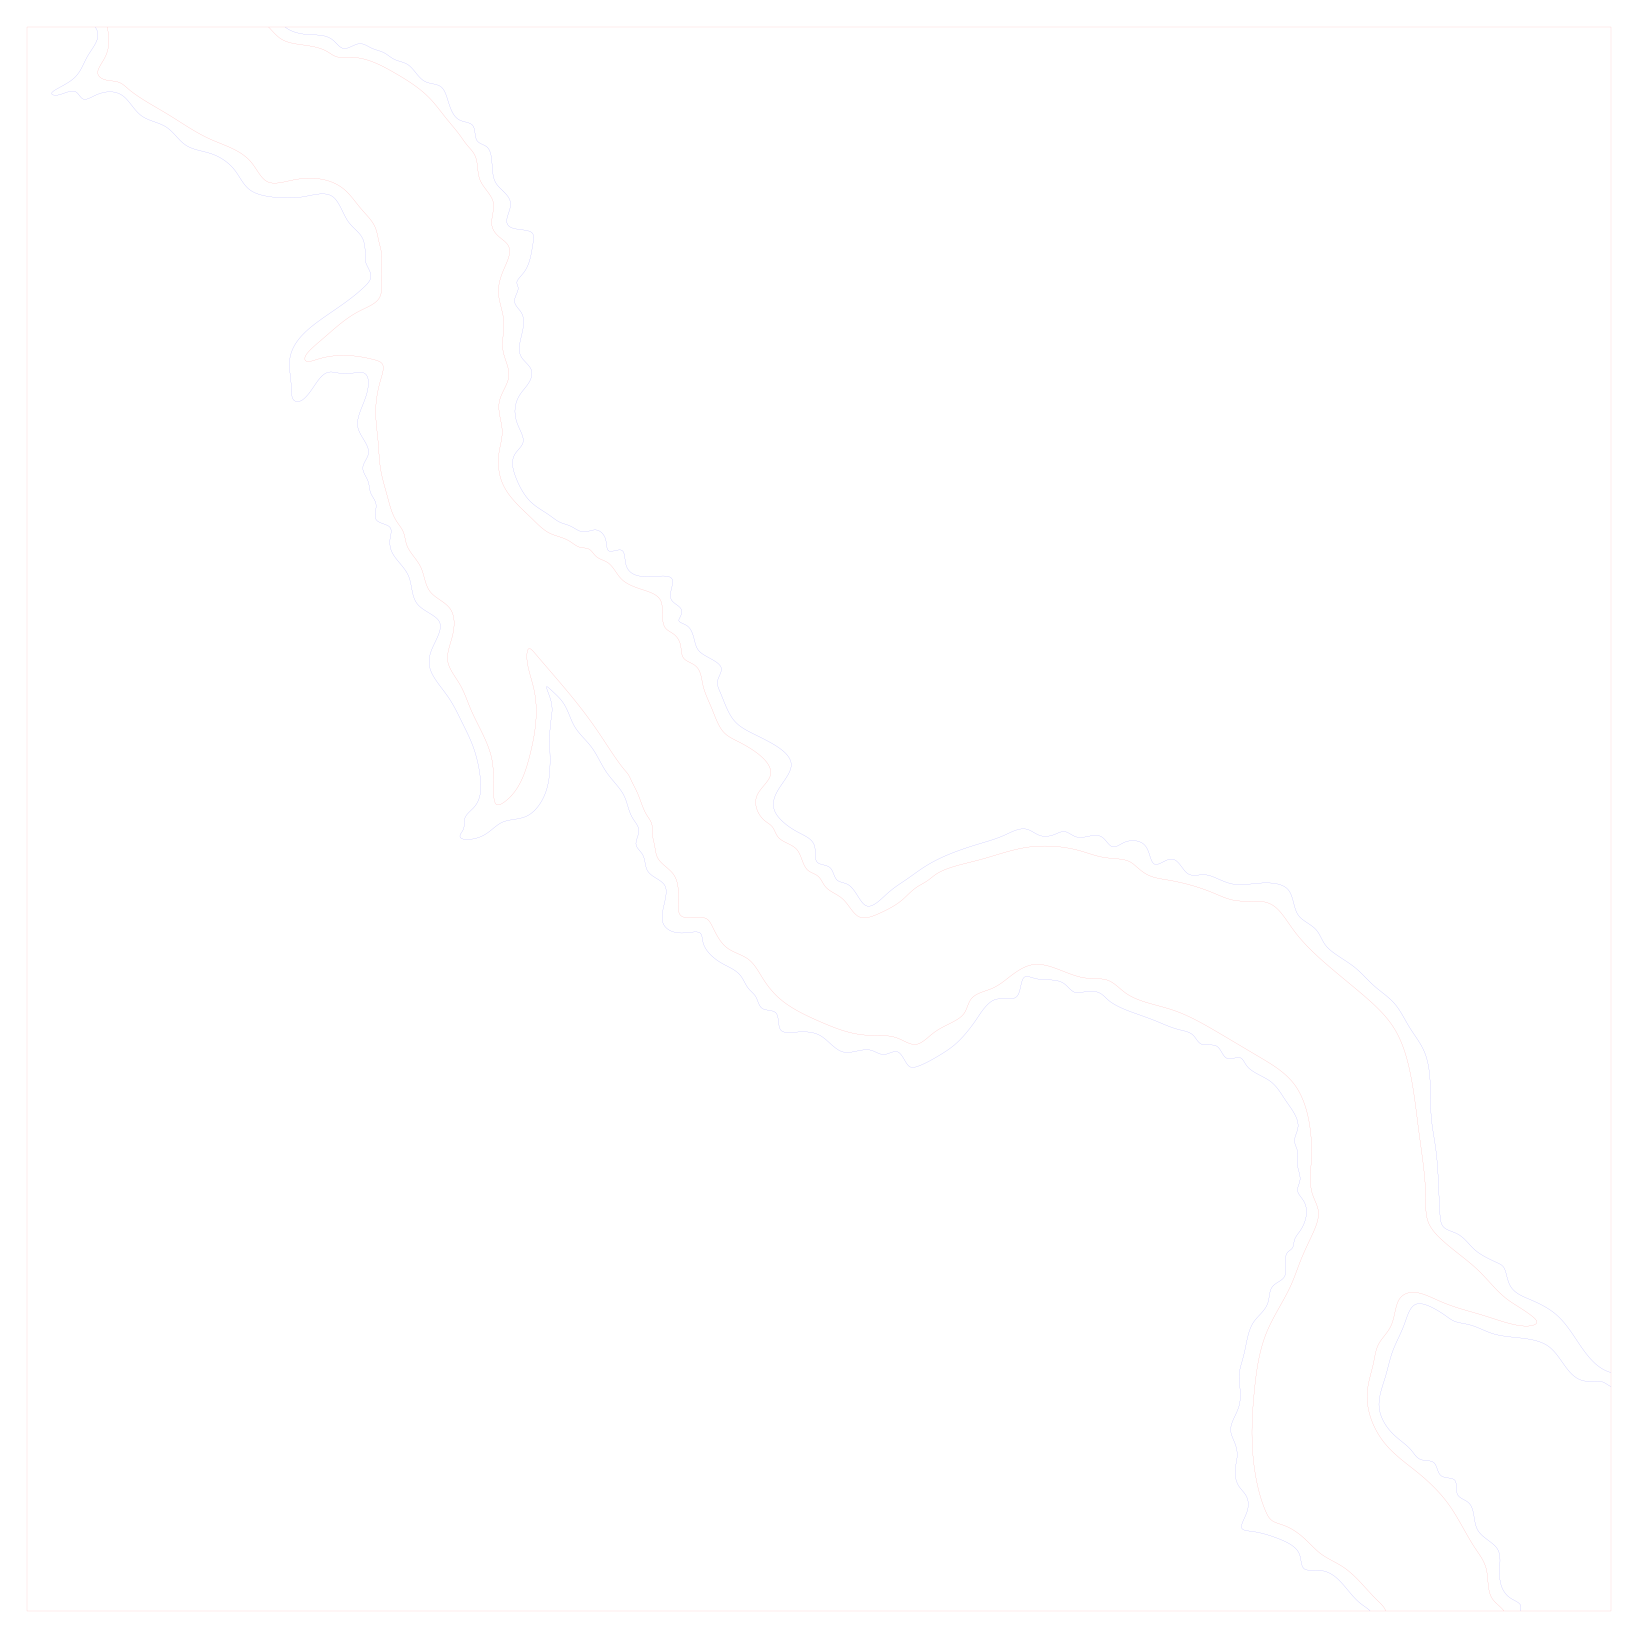

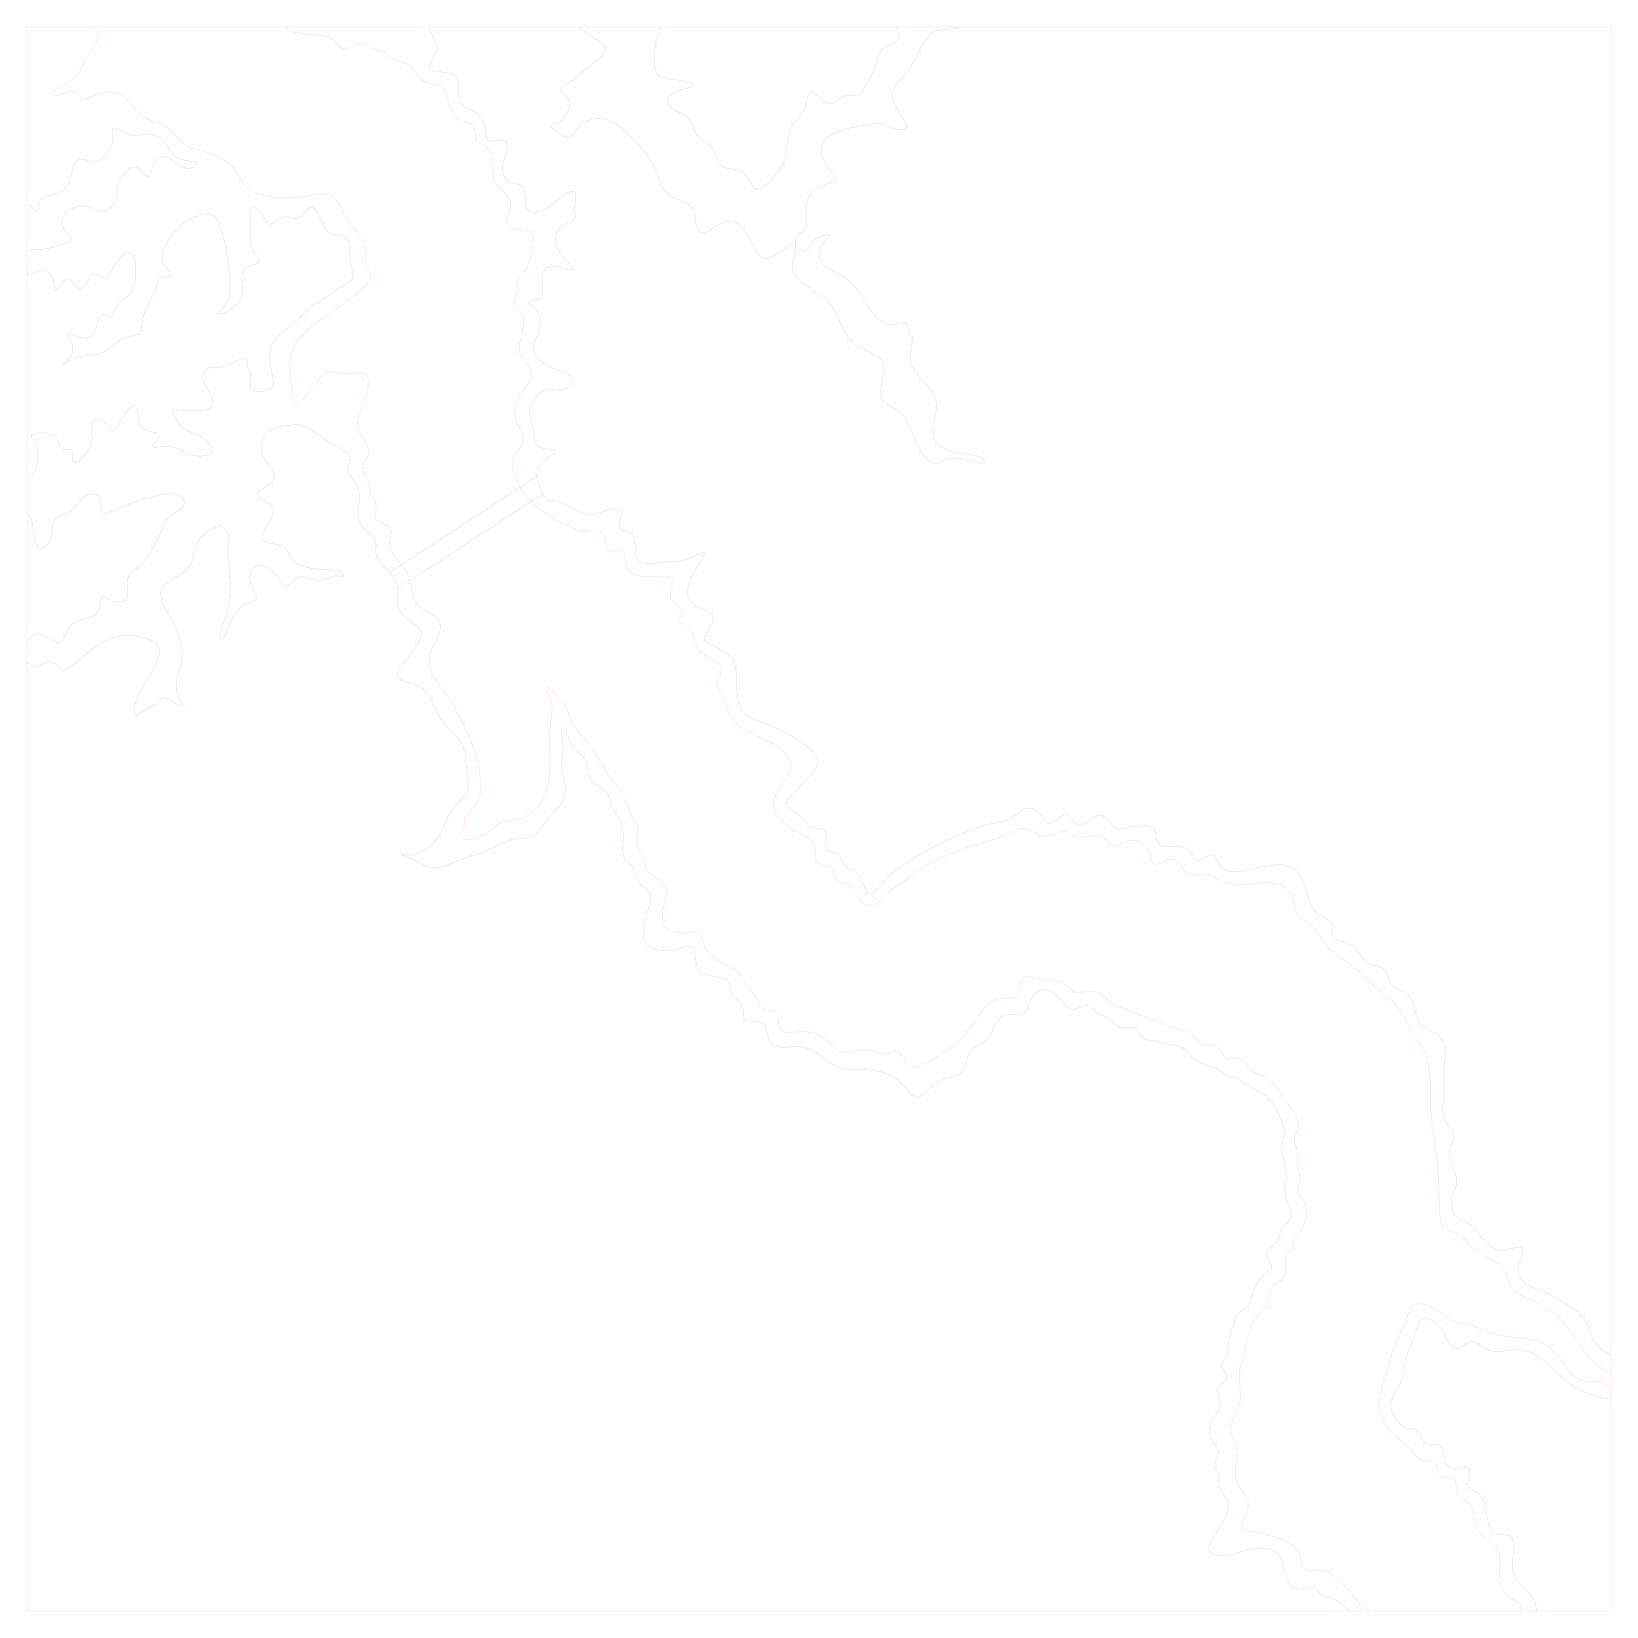

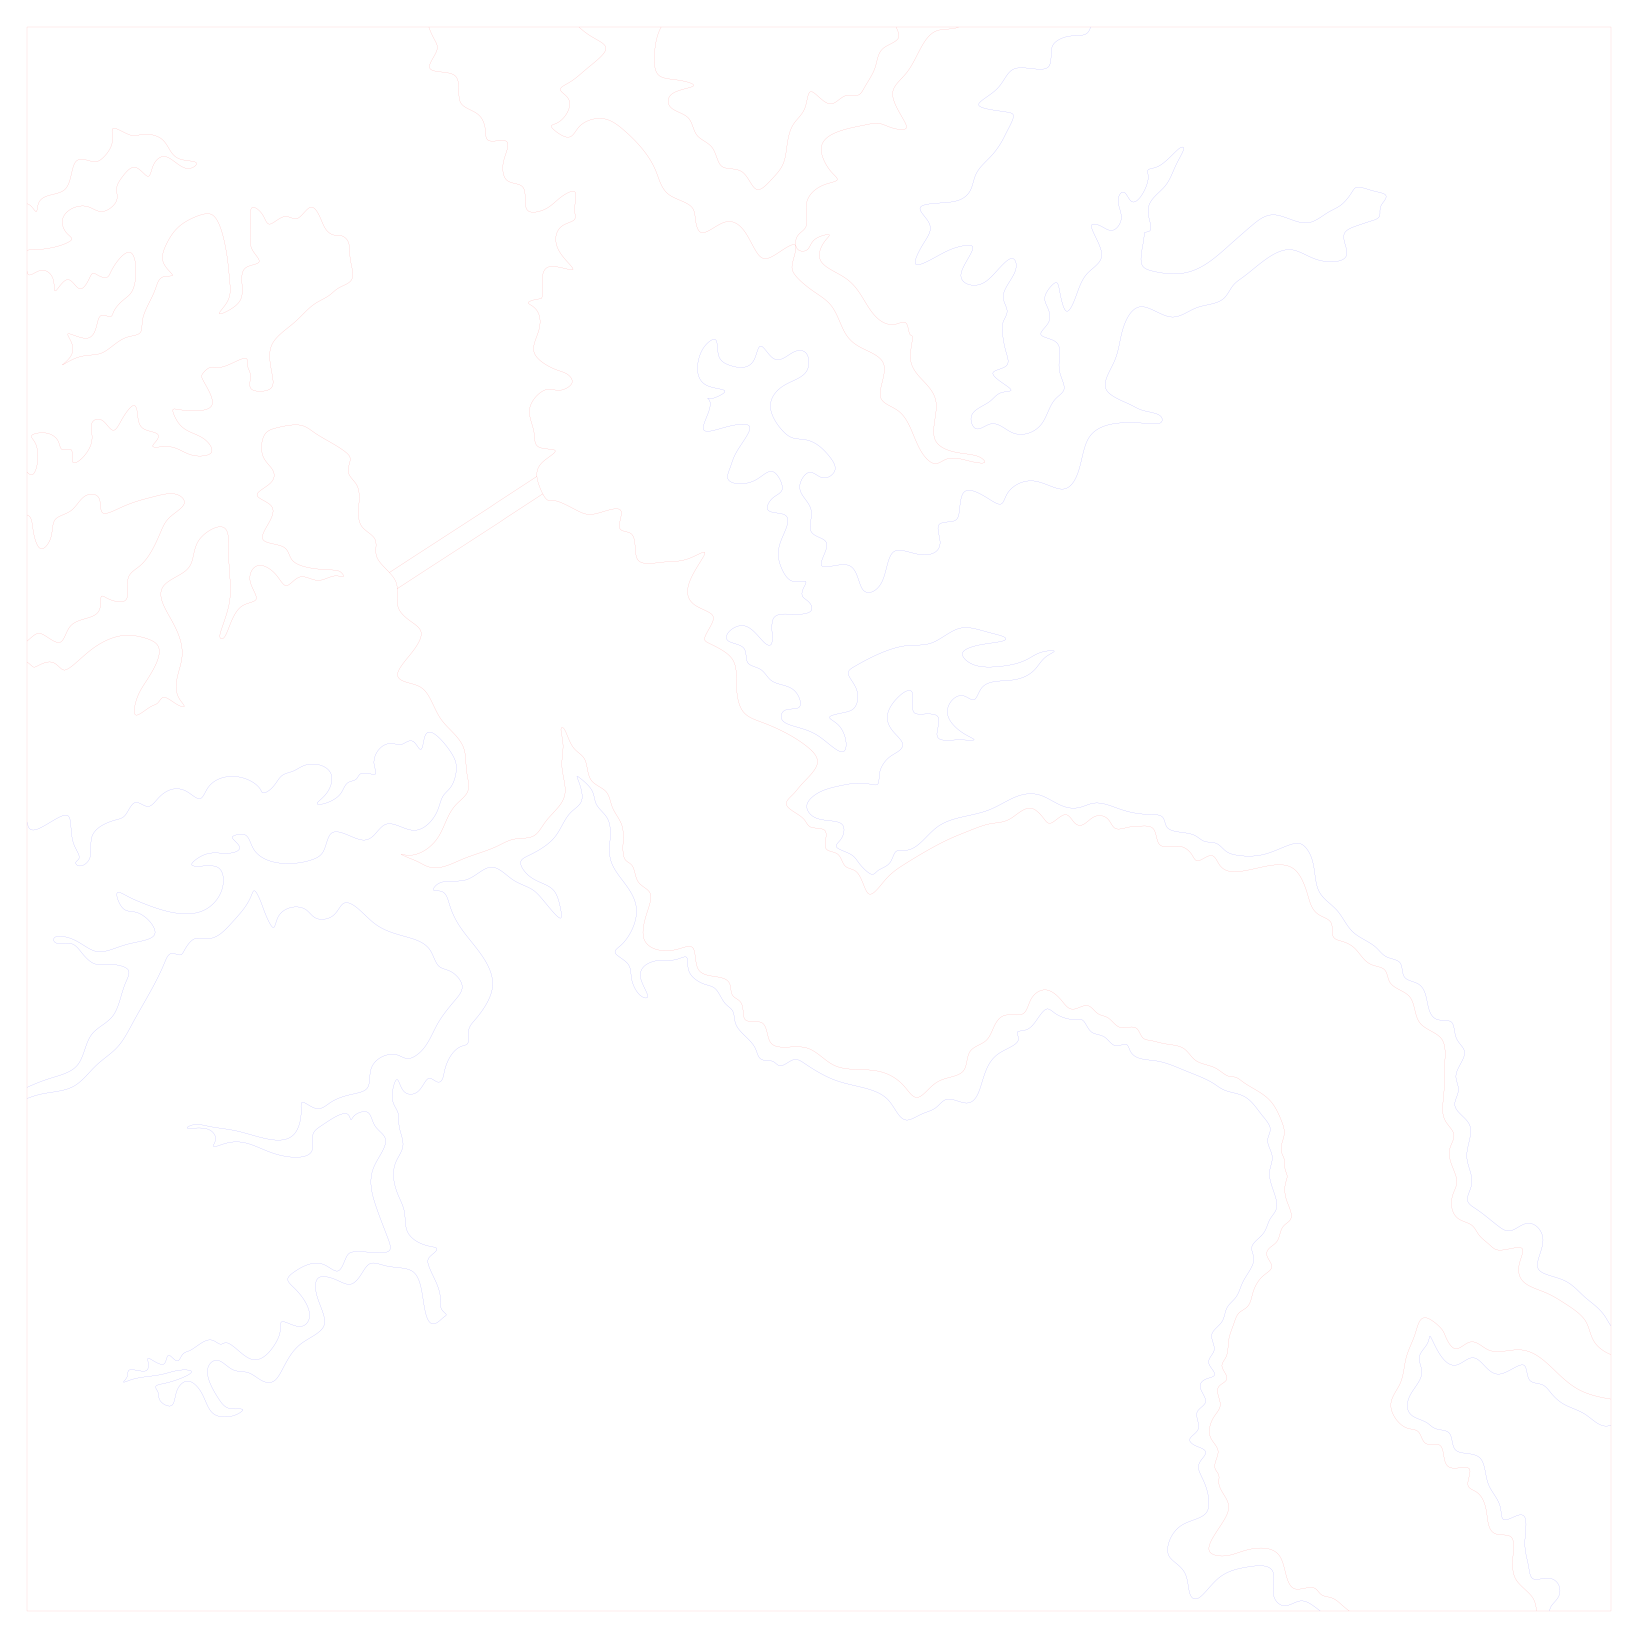

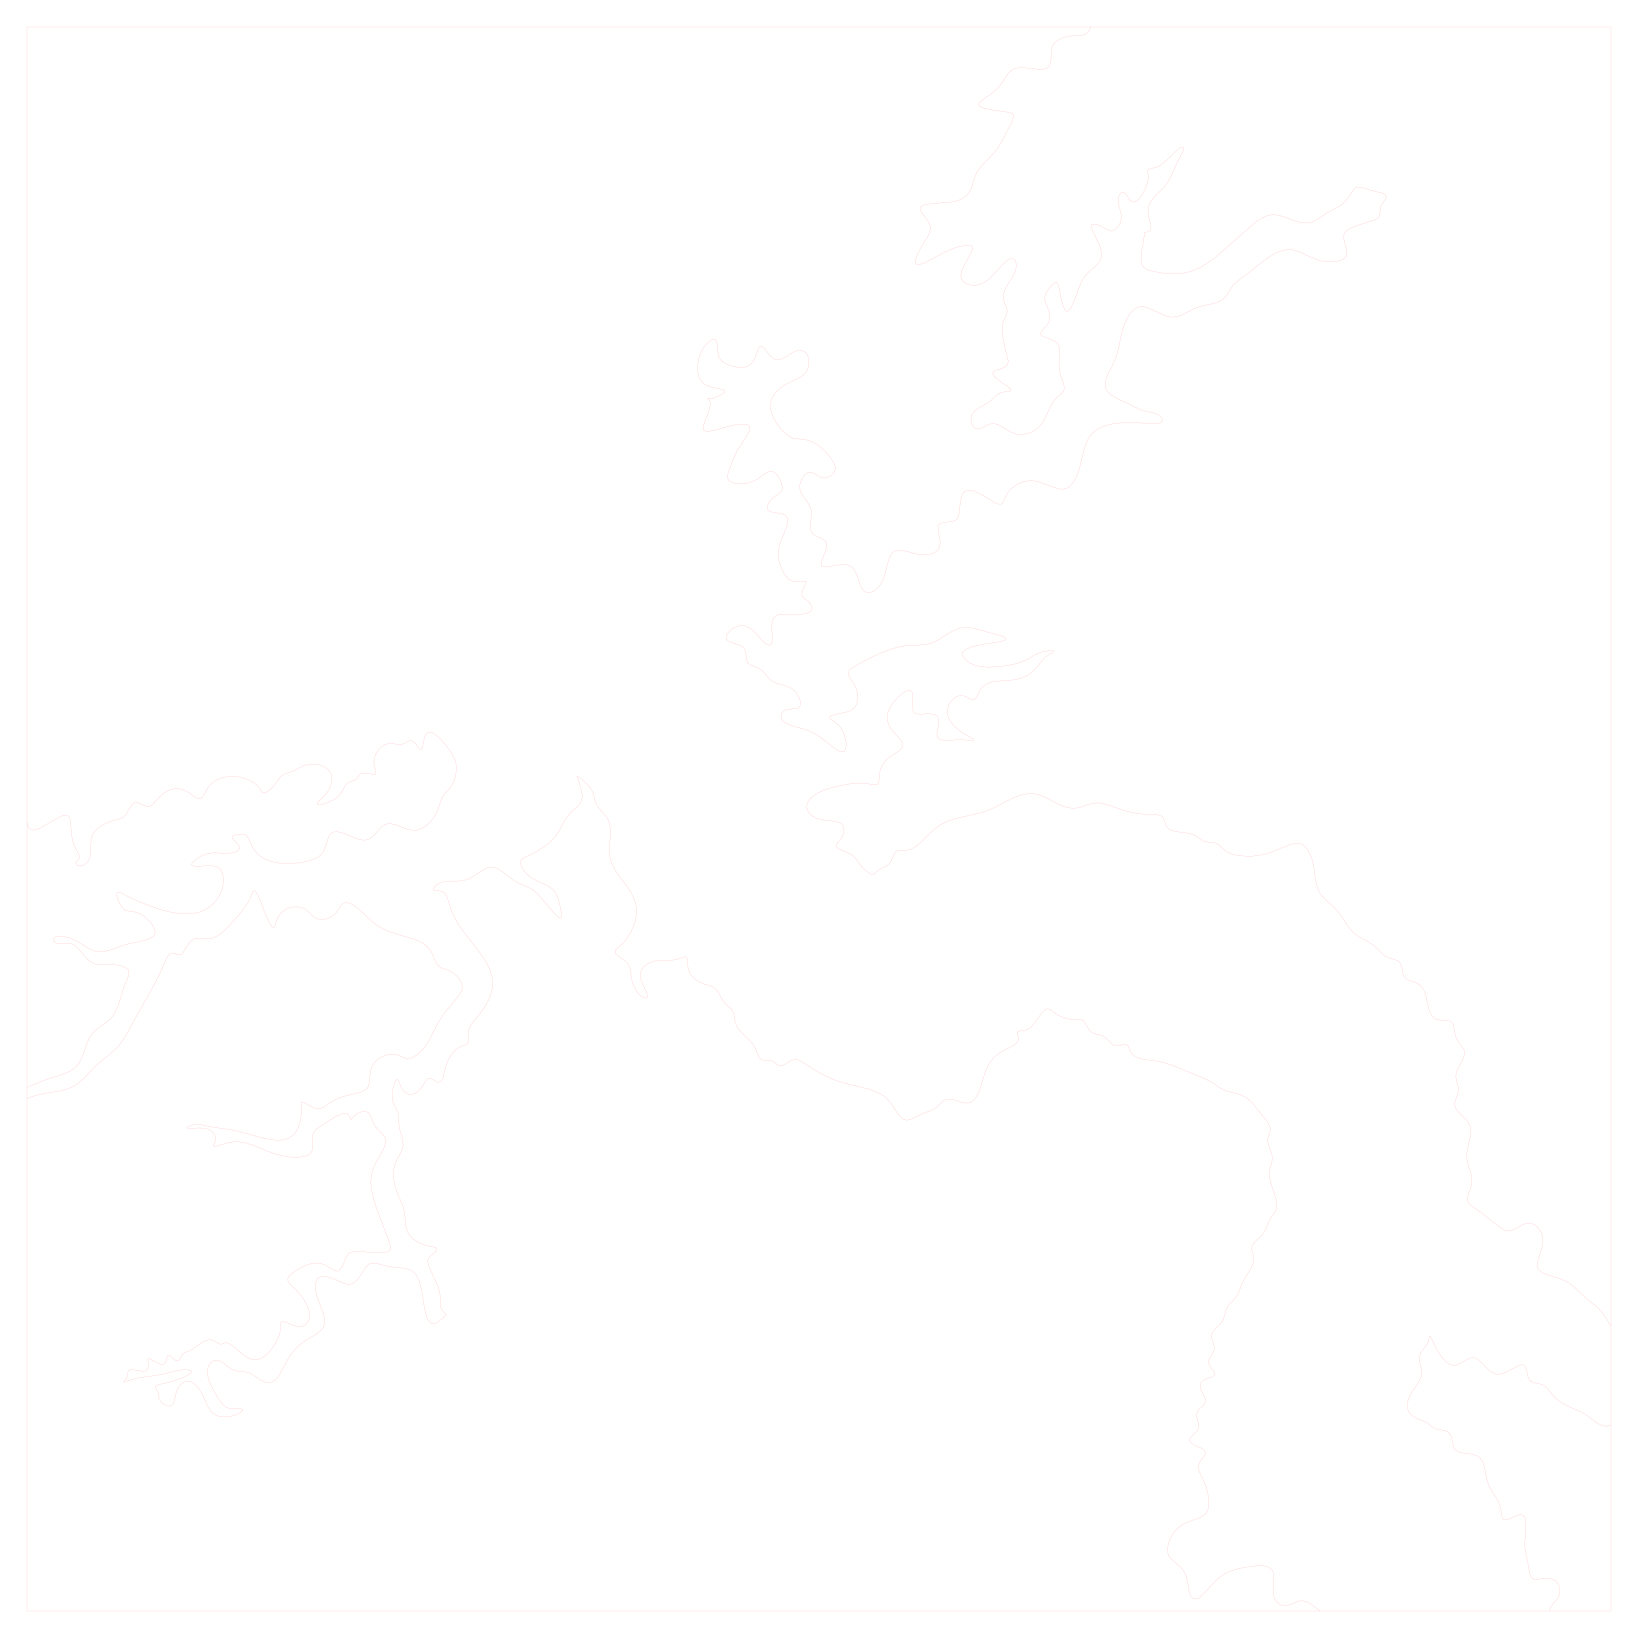

In [19]:
# Save layers as output svg files

output_dir = os.path.join(pwd,'output_layers')
os.makedirs(output_dir,exist_ok=True)

size = 22            # Size of piece [inches]
lw = 0.072               # Linewidth [pts]
cut_color = '#FF0000'
etch_color = '#0000FF'

pad = 100 # Extra padding to ensure border isn't cut off in image [m]

xmin,ymin,xmax,ymax = border.bounds.values[0]

km_per_in = ((xmax-xmin)/1000)/size
in_per_km = np.round(1/km_per_in,3)

print(f'1 km = {in_per_km} in')

pad_in = pad/1000/km_per_in

n = len(smoothed_contours)

# Start with border

fig,ax = plt.subplots(figsize=(size+2*pad_in,size+2*pad_in))

border.plot(ax=ax,color=cut_color,linewidth=lw)

ax.set_xlim([xmin-pad,xmax+pad])
ax.set_ylim([ymin-pad,ymax+pad])
ax.axis('off')
fig.subplots_adjust(bottom=0,top=1,right=1,left=0)

outname = os.path.join(output_dir,'Layer0_base.svg')
fig.savefig(outname,bbox_inches='tight', pad_inches=0)

# Move on to each contour

for i in range(n):
    
    fig,ax = plt.subplots(figsize=(size+2*pad_in,size+2*pad_in))
    
    elev = smoothed_contours['ELEV'].values[i]
    m_cut = (smoothed_contours['ELEV'] == elev)
    
    if i < n-1:
        next_elev = smoothed_contours['ELEV'].values[i+1]
        m_etch = (smoothed_contours['ELEV'] == next_elev)
        smoothed_contours[m_etch].plot(ax=ax,color=etch_color,linewidth=lw)
        
    smoothed_contours[m_cut].plot(ax=ax,color=cut_color,linewidth=lw)
    
    border.plot(ax=ax,color=cut_color,linewidth=lw)
    
    ax.set_xlim([xmin-pad,xmax+pad])
    ax.set_ylim([ymin-pad,ymax+pad])
    ax.axis('off')
    fig.subplots_adjust(bottom=0,top=1,right=1,left=0)

    outname = os.path.join(output_dir,f'Layer{i+1}_ELEV_{elev}.svg')
    fig.savefig(outname,bbox_inches='tight', pad_inches=0)